SENTIMENT ANALYSIS USING LLMs.

In [1]:
# Libraries.
import pandas as pd
import matplotlib.pyplot as plt
import csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, AdamW

C:\Users\asael\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
# Reading news corpus.
news = pd.read_csv('news_data.csv')

In [3]:
# Counting NaN values and filling with ''.
news['content'] = news['content'].fillna('')
news['text'] = news['title'] + ' ' + news['description'] + ' ' + news['content']

In [4]:
# Function for predict sentiment for each new in 2 targets: positive and negative.
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1)
    sentiment = torch.argmax(probabilities, dim=1).item() + 1  # 1 to 5 rating.
    
    # Mapping each target.
    if sentiment in [1, 2]:
        return 'Negativo'
    else:
        return 'Positivo'

In [5]:
# Using LLM BERT Sentiment.
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

C:\Users\asael\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [6]:
# Generating target for the corpus.
news['sentiment'] = news['text'].apply(predict_sentiment)

In [10]:
# Mapping targets in numbers.
label_mapping = {'Negativo': 0, 'Positivo': 1}
news['rating'] = news['sentiment'].map(label_mapping)

In [15]:
# Veryfing if we got it.
neutral_news = news.loc[news['sentiment'] == 'Positivo']
print(neutral_news[['text', 'sentiment']])

                                                  text sentiment
8     Bitcoin range recovery could boost UNI, SUI, ...   Neutral
13    Sub $50K Bitcoin correction remains in play a...   Neutral
48   Proton Wallet Review: A Bitcoin Software Walle...   Neutral
91    Bitcoin’s ‘local market structure’ could push...   Neutral
157   Bitcoin weekly RSI sparks &#039;intermediate&...   Neutral
159   Bitcoin is pinned below $65K but several mark...   Neutral
180   Bitcoin analysis sees BTC price gains on Coin...   Neutral
219  Bitcoin Enters Positive Seasonality Period, Bu...   Neutral


In [20]:
# Results.
print(news[['text', 'sentiment']])

                                                  text sentiment
0     Bitcoin in ‘seasonal slog’ with slim chance o...  Negativo
1     Bitcoin traders celebrate ‘good news’ as BTC ...  Positivo
2     Bitcoin price shows strength above its recent...  Positivo
3     Bitcoin ETFs record combined $1.2B in outflow...  Negativo
4     Is crypto entering a bear market? — 5 Things ...  Negativo
..                                                 ...       ...
236  Substantial Net Outflows for Bitcoin, Ethereum...  Negativo
237  These Alts Dumped the Most Weekly as Bitcoin (...  Negativo
238  Is Bitcoin Gearing for a Major Move to $65,000...  Negativo
239  The Privacy Imperative: Achieving true final s...  Negativo
240  Bitcoin Price Forecast as ETF Inflows Signal I...  Positivo

[241 rows x 2 columns]


In [22]:
# Splitting the corpis in 80% train set and 20% for test set.
train_data, test_data = train_test_split(news, test_size=0.2, random_state=42)
# Splitting train set in 80% to get the validation set in 20%.
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

print(len(train_data))
print(len(test_data))
print(len(val_data))

153
49
39


In [23]:
# Class.
class Dataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels=None):
        self.encodings = tokenizer(texts, padding=True, truncation=True, max_length=512)
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.encodings["input_ids"])

In [24]:
# Datasets for each set.
train_dataset = Dataset(train_data['text'].tolist(), train_data['rating'].tolist())
val_dataset = Dataset(val_data['text'].tolist(), val_data['rating'].tolist())
test_dataset = Dataset(test_data['text'].tolist(), test_data['rating'].tolist())

In [25]:
# Function metrcis.
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="macro")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [26]:
# Configuration for training.
training_args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=100,
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    seed=0,
    load_best_model_at_end=True,
    fp16=False
)

In [27]:
# AdamW Optimizer.
optimizer = AdamW(model.parameters(), lr=2e-5)

# Configurar el `Trainer`
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    optimizers=(optimizer, None)
)

# Train the model.
trainer.train()

C:\Users\asael\anaconda3\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\asael\anaconda3\Lib\site-packages\accelerate\accelerator.py:444: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss


TrainOutput(global_step=30, training_loss=0.48205703099568686, metrics={'train_runtime': 1944.4299, 'train_samples_per_second': 0.236, 'train_steps_per_second': 0.015, 'total_flos': 120771227390976.0, 'train_loss': 0.48205703099568686, 'epoch': 3.0})

In [28]:
# Evaluating model in test set.
predictions = trainer.predict(test_dataset)
print(predictions.metrics)

{'test_loss': 0.3910849094390869, 'test_accuracy': 0.8979591836734694, 'test_f1': 0.8857808857808858, 'test_runtime': 72.7682, 'test_samples_per_second': 0.673, 'test_steps_per_second': 0.055}


ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of labels (3).

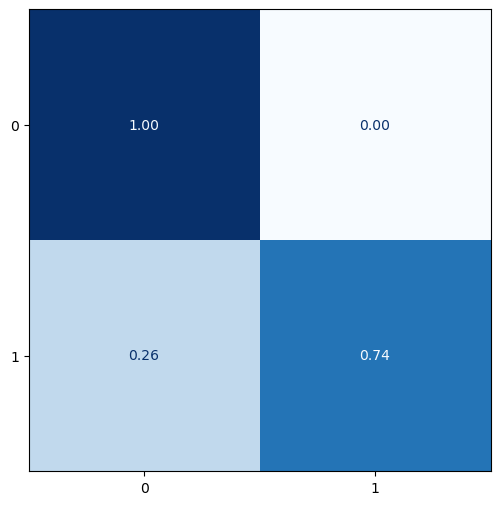

In [33]:
# Confussion matrix to looke better the results.
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
import numpy as np

y_preds = np.argmax(predictions.predictions, axis=-1)
y_test = test_data['rating'].tolist()

# Graficar la matriz de confusión
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

label_name = ['Negativo', 'Positivo']
plot_confusion_matrix(y_preds, y_test, label_name)

# Mostrar reporte de clasificación
print(classification_report(y_test, y_preds, target_names=label_name))